# CNRS Applications study
---

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the data
---

In [28]:
pd_candidates = pd.read_json('complete.json')

## Some way to plot the data
---

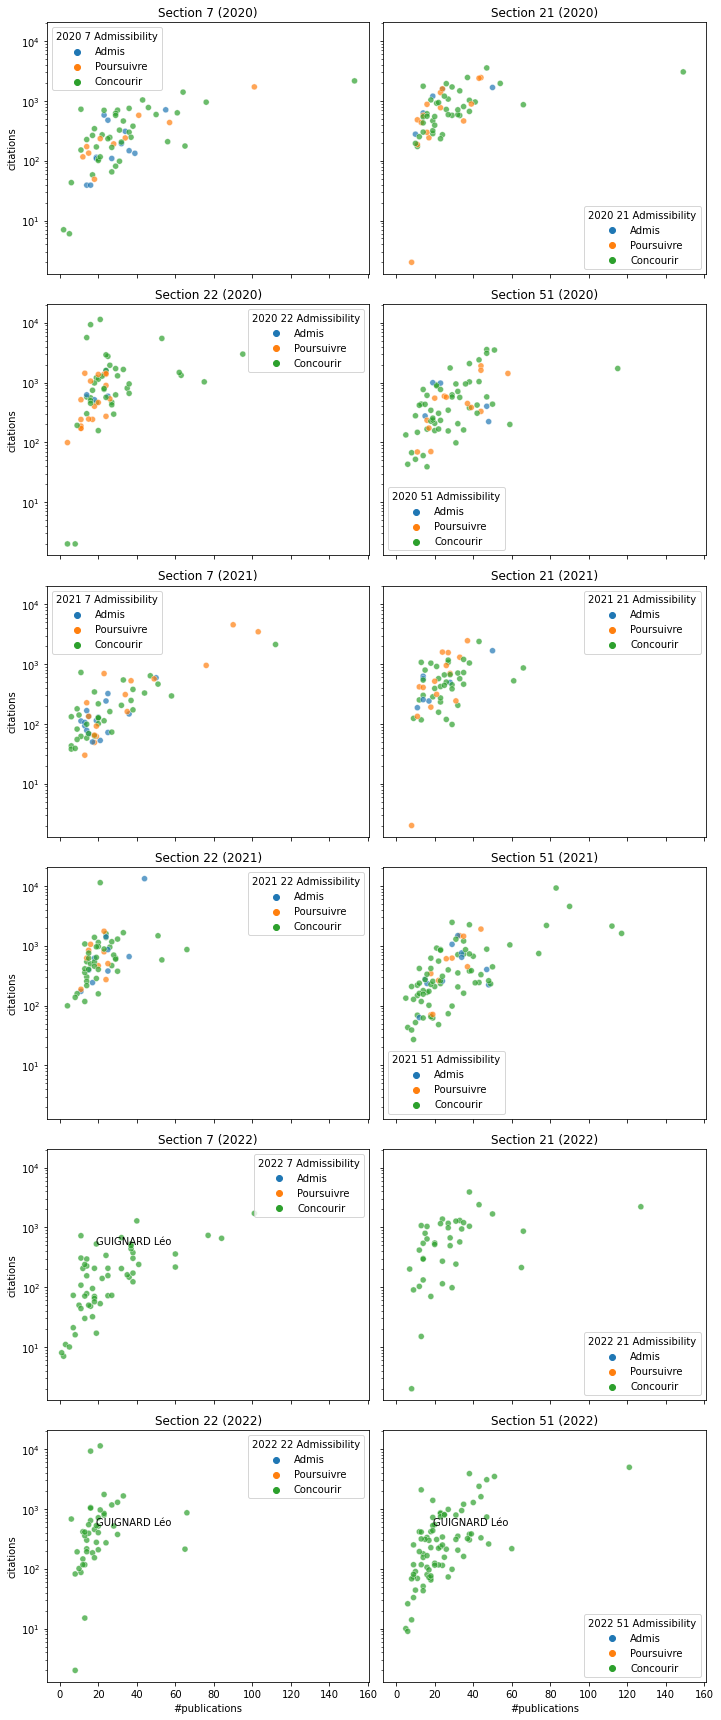

In [29]:
to_look = ['GUIGNARD Léo']
hue_order = ['Admis', 'Poursuivre', 'Concourir']
fig, axes = plt.subplots(6, 2, figsize=(10, 24), sharex=True, sharey=True)
axes = axes.flatten()
[ax.set(yscale='log') for ax in axes]
i = 0
for year in range(2020, 2023):
    for section in ['7', '21', '22', '51']:
        ax = axes[i]
        i += 1
        tmp = pd_candidates[pd_candidates[f'{year} {section} section']]
        sns.scatterplot(ax=ax, data=tmp, x='#publications', y='citations',
                        hue=f'{year} {section} Admissibility',
                        hue_order=hue_order, alpha=.7)
        ax.set_title(f'Section {section} ({year})')
        for n in to_look:
            if n in pd_candidates[pd_candidates[f'{year} {section} section']]['Name'].to_list():
                x = pd_candidates[pd_candidates['Name']==n]['#publications']
                y = pd_candidates[pd_candidates['Name']==n]['citations']
                ax.text(x, y, n)
fig.tight_layout()
# fig.savefig(f'publication_plot_all_Years.png')
    